# Generación de Predicciones con Regresión Lineal
Este notebook implementa una regresión lineal para predecir valores en un conjunto de datos simulados.

## 1. Importación de Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.arima_process as arima_process
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.seasonal import _extrapolate_trend
from statsmodels.tsa.filters.filtertools import convolution_filter


## 2. Extracción y limpieza de datos

<span style="color:white; font-weight:bold">2.1 Extracción</span>

Los datos se generaron directamente de la base de datos MSSQL con las ventas reales de la empresa HBS-Delli, del 2020 a la fecha (diciembre 2024).

In [3]:
df = pd.read_excel("../data/Ventas_CapstoneProject_Agrupado.xlsx", sheet_name="Ventas")

**2.2 funciones**

In [7]:
def eliminar_datos_atipicos(input_df):
    
    # Calcular Q1 (percentil 25) y Q3 (percentil 75)
    Q1 = input_df['cantidad'].quantile(0.25)
    Q3 = input_df['cantidad'].quantile(0.75)
    IQR = Q3 - Q1

    # Definir límites para valores no atípicos
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar el DataFrame eliminando valores atípicos
    df_sin_picos = input_df[(input_df['cantidad'] >= lower_bound) & (input_df['cantidad'] <= upper_bound)]

    #Comentar si se quieren utilizar datos atipicos
    # df = df_sin_picos

    return df_sin_picos

<span style="color:white; font-weight:bold">2.2 Limpieza</span>

La mayor parte de la limpieza de datos se realizaron directamente en la base de datos MSSQL, sin embargo se utilizo pandas para realizar una validación de la información y preparar el dataset para su analisis.

In [6]:
#validar nulos
if df.isnull().sum().sum() > 0:
    df = df.dropna()
    print("Se eliminaron las filas con valores nulos.")
else:
    print("No se encontraron valores nulos en el DataFrame.")

# Preparando información de la venta
df = df.rename(columns={'FechaEmision': 'fecha_emision'
                        , "Empresa": "empresa"
                        })

# Preparando informacion del artículo
df['numero_articulo'] = pd.to_numeric(
                                    df['Articulo'].str.extract(r'(\d+)')[0]     # Extraer solo números
                                    ,errors='coerce'                            # Convertir valores inválidos a NaN
                                    ).fillna(0).astype(int)                     # Reemplazar NaN por 0 y convertir a entero
df = df.rename(columns={"Articulo": "articulo"
                        ,'Desc_Articulo': 'desc_articulo'
                        , 'FechaEmision': 'fecha_emision'
                        , "Empresa": "empresa"
                        , "Mov": "mov"
                        , "MovId": "movId"
                        , "Lote": "lote"
                        })

# Preparando información del cliente
df = df.rename(columns={'Numero_Cliente': 'numero_cliente'
                        , 'Nombre_Cliente': 'nombre_cliente'
                        , "Rama": "rama_cliente"
                        , "Tipo" : "tipo_cliente"
                        , "Linea": "linea"
                        , "Modulo": "modulo"
                        })
df['numero_cliente'] = df['numero_cliente'].fillna('Desconocido')

# Preparando información de las cantidad
df = df.rename(columns={"Cantidad": "cantidad"
                        , "Lote": "lote"
                        , "UM": "unidad_medida"
                        , "Precio": "precio"
                        , "SubTotal": "subTotal"
                        , "DescuentoLineal": "descuento_lineal"
                        , "IVA": "iva"
                        , "IEPS": "ieps"
                        , "ImporteTotal": "importe_total"
                        , "Costo_Unitario": "costo_unitario"
                        , "Costo_Total": "costo_total"
                          })
# validando columna de tipo fecha
if (df["fecha_emision"].dtypes=="object"):
    df["fecha_emision"] = pd.to_datetime(df["fecha_emision"], errors='coerce', format='%d/%m/%Y')
    print(f"La columna '{"fecha_emision"}' ha sido convertida a datetime.")
else:
    print(f"La columna '{"fecha_emision"}' ya es de tipo datetime, no es necesario convertir.")

# Eliminando información no requerida para el analisis
df = df.drop(columns=["IEPS_Cuota", "Numero_Orden"])

df = eliminar_datos_atipicos(df)

No se encontraron valores nulos en el DataFrame.
La columna 'fecha_emision' ya es de tipo datetime, no es necesario convertir.


<h2>Split historical and future data</h2>

In [18]:
df["fecha_emision"] =  pd.to_datetime(df["fecha_emision"], errors="coerce" , format="%d/%m/%Y")     #Convirtiendo fecha_emision en conjunto de fechas
df = df.dropna(subset=["fecha_emision"])                                                            #Eliminando posibles fechas invalidas

# Filtrar datos de entrenamiento, validación y futuros
y_hist      = df[df['fecha_emision'] <= '2023-12-01']
y_hist      = y_hist[y_hist['fecha_emision'] >= '2021-01-01']
y_hist      = y_hist.groupby("fecha_emision")["cantidad"].sum()
y_future    = df[df['fecha_emision'] >= '2023-12-01']
y_future    = y_future[y_future['fecha_emision'] <= '2024-12-01']
y_future    = y_future.groupby("fecha_emision")["cantidad"].sum()

train_full  = df

C:\Users\j.carrillo\AppData\Local\Temp\ipykernel_16580\1982957197.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


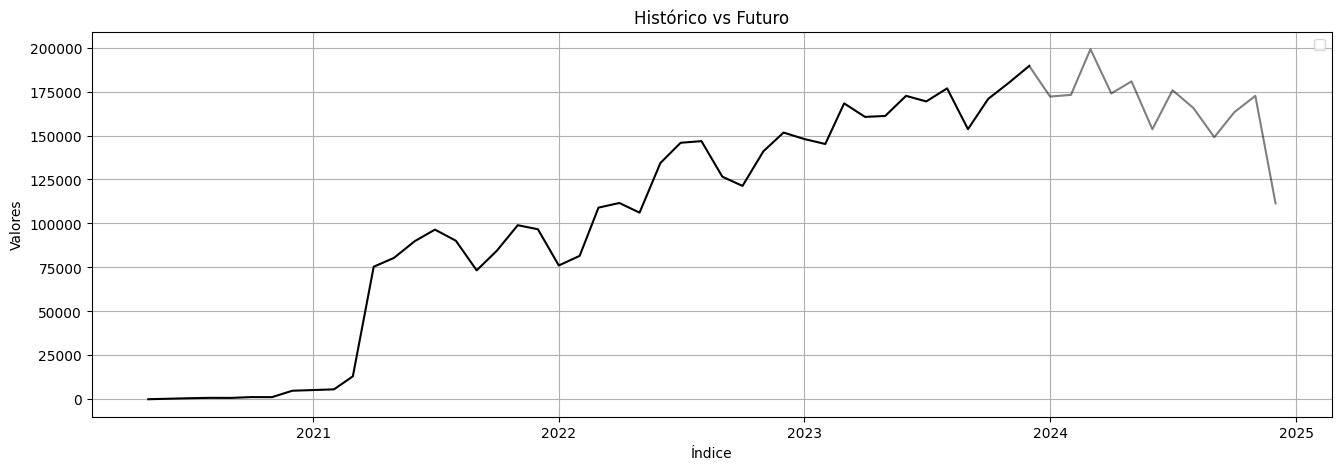

In [29]:
split_index = len(y_hist)   # Último índice de `y_hist`
plt.figure(figsize=(16,5))
plt.plot(y_hist, 'k')
plt.plot(y_future, 'k', alpha=0.5)
#plt.axvline(x=split_index, color='red', linestyle='--', linewidth=2, label='Fin de Histórico')

# Agregar etiquetas y leyenda
plt.xlabel('Linea de tiempo')
plt.ylabel('Ventas')
plt.title('Histórico vs Futuro')
plt.legend()
plt.grid(True)

plt.show()

**paso1: Calculamos la tendencia**

In [ ]:
periodos = 12*1
filtro      = np.ones(periodos+1)
filtro[0]   = 0.5
filtro[1]   = 0.5
filtro      /= periodos

sum(filtro)

tendencia   = convolution_filter(y_hist, filtro)

In [76]:
tendencia.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 43 entries, 2020-05-01 to 2023-12-01
Series name: cantidad
Non-Null Count  Dtype  
--------------  -----  
31 non-null     float64
dtypes: float64(1)
memory usage: 688.0 bytes


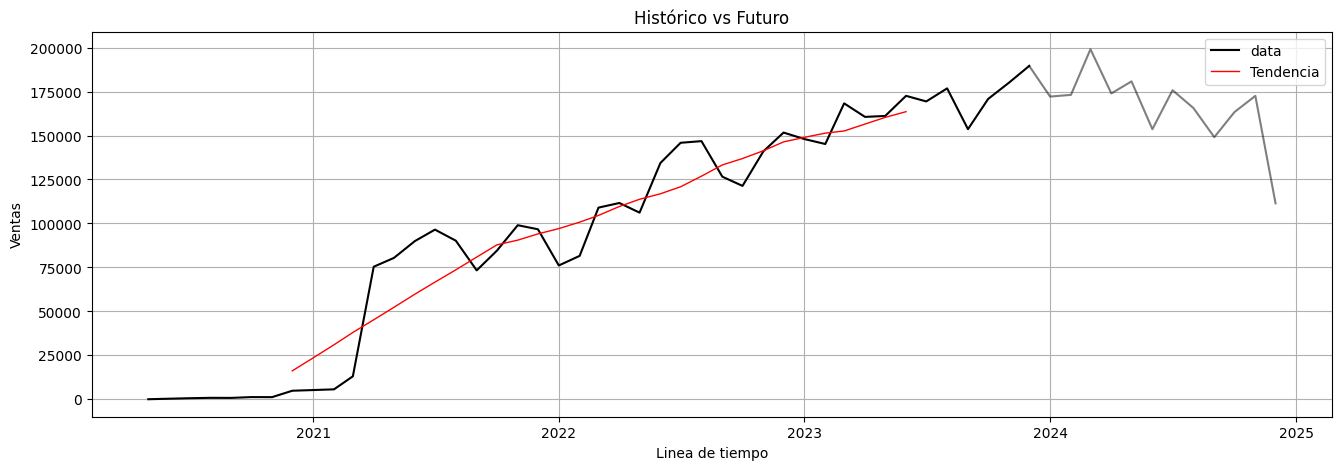

In [46]:
plt.figure(figsize=(16,5))
plt.plot(y_hist, 'k', label="data")
plt.plot(tendencia, 'r', linewidth=1, label="Tendencia")
plt.plot(y_future, 'k', alpha=0.5)
#plt.axvline(x=split_index, color='red', linestyle='--', linewidth=2, label='Fin de Histórico')

# Agregar etiquetas y leyenda
plt.xlabel('Linea de tiempo')
plt.ylabel('Ventas')
plt.title('Histórico vs Futuro')
plt.legend()
plt.grid(True)

plt.show()

**Analizamos los datos elimininando la tendencia**

In [77]:
tendencia["fecha_emision"]

KeyError: 'fecha_emision'

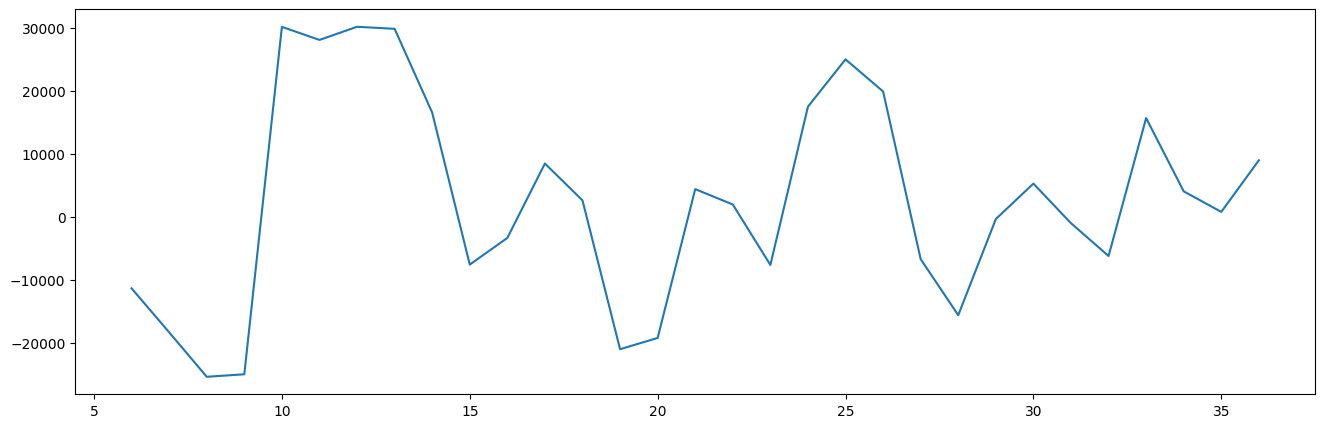

In [59]:
#tendencia   = _extrapolate_trend()(tendencia.dropna(), 13)
detrended   = y_hist - tendencia 
detrended   = detrended.to_numpy()

plt.figure(figsize=(16,5))
plt.plot(detrended)


<h2>Create a stationay time series</h2>

In [111]:
process = arima_process.ArmaProcess(ar=[1, -0.8], ma=[1])

In [ ]:
z = process.generate_sample(nsample=1000)
plt.figure(figsize=(10,5))
plt.plot(z, linewidth=2, marker=".")

<h2>Gráfica de autocorrelaciones</h2>

In [8]:
acf = process.acf(lags=20)
plt.figure(figsize=(10,4))
plt.stem(acf)
plt.title(f"Gráfica de autocorrelacion")
plt.xlabel("Número de lags")
plt.ylabel("Correlación")
plt.xticks(ticks=range(0, 20, 2))
plt.show()

NameError: name 'process' is not defined

Esta gráfica indica que las autocorrelaciones tiene un disminución exponencial con el número de lags, lo cual indica que es un proceso tipico stacionario

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
tsaplots.plot_acf(z, lags=20, ax=ax)
plt.show()

In [ ]:
df.drop(columns=["fecha_emision"], inplace=True)

In [ ]:
df_cantidad = df.groupby("fecha_emision")[["cantidad"]].sum().reset_index()
df_cantidad = df_cantidad.set_index(pd.to_datetime(df_cantidad["fecha_emision"]))
df_cantidad.drop(columns=["fecha_emision"], inplace=True)
df_cantidad.plot()

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
tsaplots.plot_acf(df_cantidad, lags=40, ax=ax)
plt.show()

In [ ]:
diff_ventas = df_cantidad.diff().dropna()
fig, ax = plt.subplots(figsize=(10,4))
tsaplots.plot_acf(diff_ventas, lags=40, ax=ax)
plt.show()

**3.1: Identificar posibles regresore**

Para determinar qué regresores adicionales serían útiles en tu modelo Prophet, debemos analizar la correlación entre la columna objetivo (Cantidad) y las demás columnas del DataFrame. Esto nos permitirá identificar qué variables explicativas tienen una relación significativa con la variable que quieres predecir

<h4>Pasos:</h4>
<ol>
    <li>Seleccionar columnas númericas</li>
    <li>calcular la correlación con la variable objetivo "Cantidad"</li>
    <li>Identificar las columnas con mas correlación</li>
</ol>

Recomendación: seleccionar las variables con mas alta correlación (+1 ó -1)

In [ ]:
# Seleccionar solo las columnas numéricas del DataFrame
numerical_cols = df.select_dtypes(include=['number']).columns

# Calcular la correlación de las columnas numéricas con 'Cantidad'
correlations = df[numerical_cols].corr()['cantidad'].drop('cantidad').sort_values(ascending=False)

# Mostrar las columnas más correlacionadas con 'Cantidad'
print("Correlaciones con la columna 'Cantidad':")
print(correlations)


In [25]:
df["fecha_emision"] =  pd.to_datetime(df["fecha_emision"], errors="coerce" , format="%d/%m/%Y")     #Convirtiendo fecha_emision en conjunto de fechas
df = df.dropna(subset=["fecha_emision"])                                                            #Eliminando posibles fechas invalidas

# Filtrar datos de entrenamiento, validación y futuros
train       = df[df['fecha_emision'] <= '2023-12-01']
train       = train[train['fecha_emision'] >= '2021-05-01']
valid       = df[df['fecha_emision'] >= '2024-01-01']
valid       = valid[valid['fecha_emision'] <= '2024-11-01']

train_full  = df

# Preparar los datos para Prophet
#train_data = train.rename(columns={"fecha_emision": "ds", "cantidad": "y"})[["ds", "y", "numero_cliente", "numero_articulo"]]
#valid_data = valid.rename(columns={"fecha_emision": "ds", "cantidad": "y"})[["ds", "y", "numero_cliente", "numero_articulo"]]

train_data = train.rename(columns={"fecha_emision": "ds", "cantidad": "y"})[["ds", "y"]]
valid_data = valid.rename(columns={"fecha_emision": "ds", "cantidad": "y"})[["ds", "y"]]



In [ ]:
valid_data

## 4. Entrenamiento del Modelo Prophet

In [ ]:
# Validando
# valid_articulo  = valid[valid['articulo'] == "DL00003413"] #.rename(columns={'fecha_emision': 'ds', 'cantidad': 'y'})
# valid_articulo  = valid_articulo.groupby("fecha_emision")[["cantidad", "costo_total"]].sum().reset_index()
# valid_articulo  = valid_articulo.rename(columns={'fecha_emision': 'ds', 'cantidad': 'y'})
# valid_articulo

valid[valid['articulo'] == "DL00003522"].groupby("fecha_emision").agg({
    "cantidad": "sum"
    ,"costo_total": "sum"
}).reset_index

In [ ]:
# Obtener la lista de artículos únicos
articulos_unicos = df['numero_articulo'].unique()

# Crear una gráfica por cada artículo
for articulo in articulos_unicos:
    # Filtrar los datos por artículo
    train_articulo  = train[train['numero_articulo'] == articulo] #.rename(columns={'fecha_emision': 'ds', 'cantidad': 'y'})
    #train_articulo  = train_articulo.groupby("fecha_emision")[["cantidad", "costo_total"]].sum().reset_index()
    train_articulo  = train_articulo.groupby("fecha_emision")["cantidad"].sum().reset_index()
    train_articulo  = train_articulo.rename(columns={'fecha_emision': 'ds', 'cantidad': 'y'})

    valid_articulo  = valid[valid['numero_articulo'] == articulo] #.rename(columns={'fecha_emision': 'ds', 'cantidad': 'y'})
    valid_articulo  = valid_articulo.groupby("fecha_emision")["cantidad"].sum().reset_index()
    valid_articulo  = valid_articulo.rename(columns={'fecha_emision': 'ds', 'cantidad': 'y'})

    # Continuar solo si hay datos suficientes
    if len(train_articulo) == 0 or len(valid_articulo) == 0:
        continue

    # Inicializar y entrenar el modelo Prophet
    model           = Prophet()
    #model.add_regressor("costo_total")
    model.fit(train_articulo)

    
    # Crear horizonte de predicción con las fechas de validación
    future          = valid_articulo[['ds']].copy()
    forecast        = model.predict(future)


    #Prediccion para los siguientes 3 Meses
    future_3_meses  = model.make_future_dataframe(periods=3, freq="ME")

    # Filtrar solo las fechas de 2024
    valid_2024      = valid_articulo
    forecast_2024   = forecast

    # Graficar valores reales y predicciones
    plt.figure(figsize=(8, 3))
    plt.plot(valid_2024['ds'], valid_2024['y'], label='Valores Reales 2024', color='blue', linewidth=2)
    plt.plot(forecast_2024['ds'], forecast_2024['yhat'], label='Predicción 2024', linestyle='--', color='orange', linewidth=2)
    plt.fill_between(forecast_2024['ds'], forecast_2024['yhat_lower'], forecast_2024['yhat_upper'], 
                     color='gray', alpha=0.3, label='Intervalo de incertidumbre')
    plt.xticks(rotation=45)

    # Configuración de la gráfica
    plt.title(f"Comparación de Valores Reales vs Predicción para Artículo: {articulo}")
    plt.xlabel("Fecha")
    plt.ylabel("Cantidad")
    plt.legend()
    plt.grid()
    plt.show()

    # Calcular métricas de desempeño
    mae = mean_absolute_error(valid_2024['y'], forecast_2024['yhat'])
    rmse = np.sqrt(mean_squared_error(valid_2024['y'], forecast_2024['yhat']))
    r2 = r2_score(valid_2024['y'], forecast_2024['yhat'])

    print(f"MAE (Error Absoluto Medio): {mae:.2f}")
    print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")
    print(f"R2 (Coeficiente de Determinación): {r2:.2f}")

    
    

In [ ]:
train_data

In [ ]:
df_86 = train_full[train_full['numero_articulo'] == 3522].groupby("fecha_emision")["cantidad"].sum().reset_index()
plt.figure(figsize=(16, 6))
plt.plot(df_86["fecha_emision"], df_86['cantidad'], label='articulo 68', color='blue', linewidth=2)
plt.xticks(rotation=45)

plt.grid()
plt.show()

## 5. Evaluación del Modelo

In [ ]:
# Evaluar el error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(valid_data['y'], forecast['yhat'])
rmse = np.sqrt(mean_squared_error(valid_data['y'], forecast['yhat']))

print(f"MAE (Error Absoluto Medio): {mae:.2f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")

## 7. Visualización de Resultados

In [ ]:
# Visualizamos las predicciones vs los datos reales
plt.scatter(X_test, y_test, color='blue', label='Datos Reales')
plt.plot(X_test, y_pred, color='red', label='Predicciones')
plt.xlabel('Feature X')
plt.ylabel('Target y')
plt.title('Regresión Lineal: Datos vs Predicciones')
plt.legend()
plt.show()

In [ ]:
# Python
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)
# fig2 = m.plot_components(forecast)

